<a href="https://colab.research.google.com/github/Hoggnation/cataloging_coherent_oscillators/blob/main/Chi_Squared_Function_on_KIC_7917485.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install lightkurve
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

In [4]:
#this means only look at top ten frequencies/peaks
num_of_peaks = 10

In [5]:
search_result = lk.search_lightcurve('KIC 7917485', mission='Kepler')
lc_collection = search_result.download_all()

In [6]:
#array of time differences, find its median, use it to calculate the max frequency
lc = lc_collection.stitch()  # Combine all light curves in lc_collection
sampling_rate_days= np.median(np.diff(lc.time))
sampling_rate_days_no_units = sampling_rate_days.value #get rid of units
f_max = 1 / (sampling_rate_days) #in days
f_max_no_units = f_max.value #get rid of units (but it's actually in 1/days)

print(sampling_rate_days_no_units)
print(f_max_no_units)
print(sampling_rate_days)

0.02043365134159103
48.938879463240205
0.02043365134159103


In [7]:
#check there is no unit
print(type(f_max_no_units), type(sampling_rate_days_no_units))

<class 'numpy.float64'> <class 'numpy.float64'>


In [8]:
#find total observation time, use it to find minimum frequency
total_observation_time = lc.time[-1] - lc.time[0] # in days
f_min = f_min = 1/ total_observation_time # in days
f_min_no_units = f_min.value #strip units (but are in 1/days)
print(f_min_no_units)
print(type(f_min_no_units))

0.0006800582252348119
<class 'numpy.float64'>


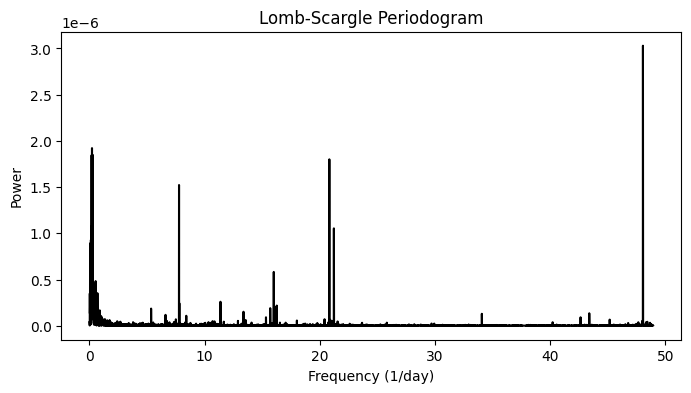

In [9]:
#trying to create periodograms with no units by manually plotting
#use lightcurve called lc to make periogram pg
pg = lc.to_periodogram(
    method='lombscargle',
    normalization='psd',
    minimum_frequency=f_min_no_units,
    maximum_frequency=f_max_no_units
)

power_no_units = np.array(pg.power.value) # an array of powers of the ligthcurve
freq_no_units = np.array(pg.frequency.value) # array of freqs of lightcurve
plt.figure(figsize=(8, 4))
plt.plot(freq_no_units, power_no_units, 'k-')  # Black line
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram")
plt.show()

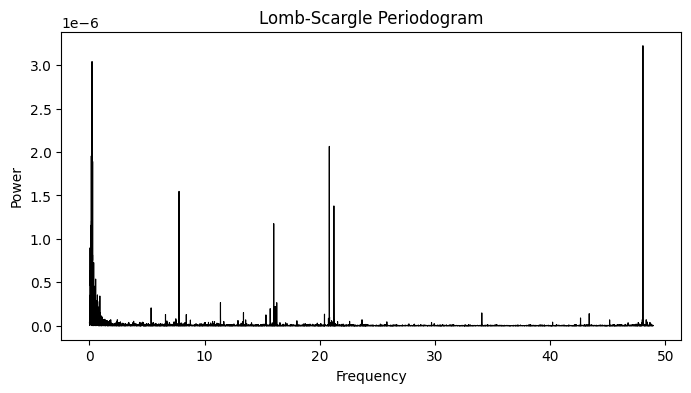

In [10]:
#trying to create periodograms of spacing f_min
frequency_grid = np.arange(f_min_no_units, f_max_no_units, f_min_no_units) #spacing with increments of f_min, starting with f_min_no_units to avoid di

#create periodogram only to get values in order to remove units
pg_spacing_fmin = lc.to_periodogram(
    method='lombscargle',
    normalization='psd',
    frequency=frequency_grid  # Unitless frequency grid
)

freq_values = np.array(pg_spacing_fmin.frequency.value)  # Remove units
power_values = np.array(pg_spacing_fmin.power.value)  # Remove units

plt.close('all')

plt.figure(figsize=(8, 4))
plt.plot(freq_values, power_values, 'k-', lw=0.8)
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram")

plt.show()

In [11]:
import numpy as np
from scipy.signal import find_peaks

In [12]:
def get_started(num_of_peaks, xs, ys):
    """

    Identifies and returns the indices of the highest peaks in a given dataset.

    Args:
        num_of_peaks (int): The number of highest peaks to return.
        xs (numpy.ndarray): The x-axis values
        ys (numpy.ndarray): The y-axis values

    Returns:
        numpy array: An array of indices corresponding to the highest peaks in `ys`.

    Bugs:
        `num_of_peaks` cannot be greater than the number of detected peaks
        `xs` or `ys` must be NumPy array


    """
    indxs, properties = find_peaks(ys)
    return indxs[np.argsort(-ys[indxs])[:num_of_peaks]]

In [13]:
indices = get_started(num_of_peaks, freq_values, power_values)
print(indices)

[70662   329   283   308 30623   236   404   376 11436 31207]


In [14]:
def check_inputs(xs):
    """

    Checks whether the input array `xs` is sorted in ascending order.

    Args:
        xs (numpy.ndarray or list): The input array to check.

    Returns:
        bool: `True` if `xs` is sorted in ascending order, otherwise `False`.

    """
    for i in range(len(xs)-1):
        if xs[i] > xs[i+1]:
            print("check_inputs(): input xs is badly ordered. Use reorder_inputs to reorder")
            return False
    return True

In [15]:
def reorder_inputs(xs,ys):
    """

    Reorders the input arrays `xs` and `ys` in ascending order of `xs`.

    Args:
        xs (numpy.ndarray): The x-axis values
        ys (numpy.ndarray): The y-axis values

    Returns:
        tuple of numpy arrays (sorted xs, sorted ys)

    Bugs:
        `xs` or `ys` must be NumPy array
        `xs` and `ys`must be same length

    """
    i = np.argsort(xs)
    return xs[i], ys[i]


In [16]:
#xlist is the teh index left to highest peak, highest peak, and the index right to teh highest peak
def design_matrix(xlist):
    """

    Constructs a design matrix for quadratic curve fitting.

    Args:
        xs (numpy.ndarray): The x-axis values

    Returns:
        3 x 3 design matrix of numpy arrays

    Bugs:
        xlist must be an numpy array

    Note:
        Note the factor of 0.5 that Hogg likes and no one else
        Also assumes xlist is ordered

    """
    return (np.vstack((xlist**0,xlist**1,0.5*xlist**2))).T

In [17]:
def fit_parabola(xs, ys, index):
    """

    Fits a quadratic function to three consecutive data points. Solves for coefficients (b,m,q) in the quadratic
    f(x) = b + m*x + (1/2) * q * x^2

    Args:
        xs (numpy.ndarray): The x-axis values
        ys (numpy.ndarray): The y-axis values
        index (int): The index of peak


    Returns:
        tuple: (b, m, q)

    Bugs:
        index-1` or `index+2` can't be out of bounds
        ``xs` or `ys` must be NumPy array


    """
    return np.linalg.solve(design_matrix(xs[index-1:index+2]), ys[index-1:index+2])

In [18]:
def refine_peak(xs, ys, index):
    """

    Refines the peak position using quadratic fit

    Args:
        xs (numpy.ndarray): The x-axis values
        ys (numpy.ndarray): The y-axis values
        index (int): The index of peak

    Returns:
        tuple: (x position of refined peak, y position of refined peak)

    Bugs:
        Must be synchronized with the design matrix


    """
    b,m,q = fit_parabola(xs, ys, index)
    x_peak = -m / q
    return x_peak, 0.5 * q * (x_peak) ** 2 + m * (x_peak) + b

In [19]:
def refine_peaks(xs, ys, indices):
    """

    Refines the peak position for a set of indices using quadratic fit

    Args:
        xs (numpy.ndarray): The x-axis values
        ys (numpy.ndarray): The y-axis values
        indices (numpy array): indices of the peaks (this should be the output of get_started()

    Returns:
        tuple of numpy arrays (array of refined x positions, array of refined y positions


    """
    foo = lambda i: refine_peak(xs,ys,i)
    xs_refined, ys_refined = zip(*list(map(foo,indices)))
    return np.array(xs_refined), np.array(ys_refined)

In [31]:
new_freqs, new_powers = refine_peaks(freq_values, power_values, indices) # this returns the new x values
#and the new y values

In [32]:
print (new_freqs, new_powers)

[48.05475521  0.22467758  0.19316354  0.21025306 20.82583281  0.1615085
  0.27557164  0.25647415  7.77780489 21.22323902] [3.23032276e-06 3.04926063e-06 3.01287734e-06 2.20810321e-06
 2.07275311e-06 1.96647188e-06 1.89357902e-06 1.73434158e-06
 1.54695314e-06 1.37923269e-06]


In [33]:
#originally the new positions function was returning the refined peaks and powers as seperate arrays, now they are arranged as tuples so that the zip function works
new_freqs, new_powers = refine_peaks(freq_values, power_values, indices)
new_positions = list(zip(new_frequencies, new_powers))
refined_frequencies, refined_powers = zip(*new_positions)

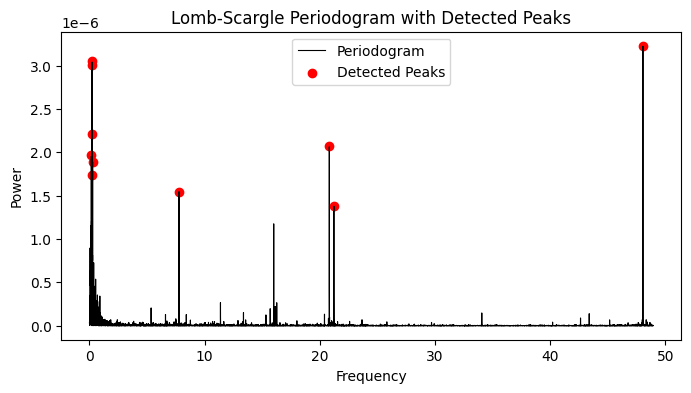

In [34]:
plt.figure(figsize=(8, 4))

plt.plot(freq_values, power_values, 'k-', lw=0.8, label="Periodogram")

plt.scatter(refined_frequencies, refined_powers, color='red', marker='o', label="Detected Peaks")

plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram with Detected Peaks")
plt.legend()

plt.show()

/usr/local/lib/python3.11/dist-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 19 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


<Figure size 1000x500 with 0 Axes>

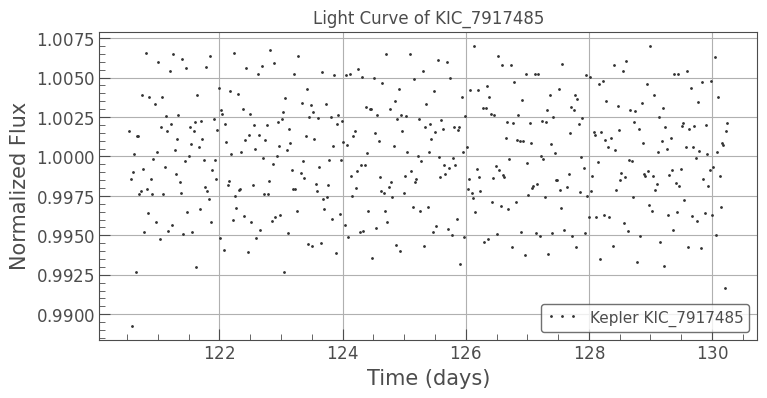

In [25]:
# Plotting lightcurve
kepler_id = "KIC_7917485"
search_result = lk.search_lightcurve(kepler_id, mission="Kepler")
lc = search_result.download().normalize()  # normalized
plt.figure(figsize=(10, 5))
lc.plot(label=f"Kepler {kepler_id}", marker='.', linestyle='none')
plt.title(f"Light Curve of {kepler_id}")
plt.xlabel("Time (days)")
plt.ylabel("Normalized Flux")
plt.grid()
plt.show()


In [35]:
# Arrays for time, flux, uncertainity, and selecting our frequency
t = lc.time.value
flux = lc.flux.value
sigma = lc.flux_err.value
max_power_index = np.argmax(new_powers)
nu = new_freqs[max_power_index]

In [36]:
# Sinusoidal model
def sinusoidal_model(t, A, B, C):
    return A * np.cos(2 * np.pi * nu * t) + B * np.sin(2 * np.pi * nu * t) + C


In [37]:
# Chi-squared function
def chi_squared(params):
    A, B, C = params
    model_flux = sinusoidal_model(t, A, B, C)
    return np.sum(((flux - model_flux) / sigma) ** 2)

In [38]:
# Initial guess for A, B, and C using LS Periodigram
amplitude_estimate = np.sqrt(np.max(refined_powers))
initial_guess = [amplitude_estimate, amplitude_estimate, np.mean(flux)]

In [41]:
# Optimizing using chi-squared
import scipy.optimize as opt
result = opt.minimize(chi_squared, initial_guess)


In [42]:
A_best, B_best, C_best = result.x
print(f"Best-fit: A={A_best}, B={B_best}, C={C_best}")


Best-fit: A=0.0017973098679089474, B=0.0017973098679089474, C=0.9999957084655762


In [75]:
# Using a combined mask to ensure the data all has the same length
combined_mask = ~t.mask & ~flux.mask & ~sigma.mask
t_clean = t[combined_mask]
flux_clean = flux[combined_mask]
sigma_clean = sigma[combined_mask]

In [76]:
# Converting masked arrays to regular numpy arrays for plotting
t_clean_unmasked = t_clean.filled(np.nan)  # this replaces masked values with NaN
flux_clean_unmasked = flux_clean.filled(np.nan)
sigma_clean_unmasked = sigma_clean.filled(np.nan)

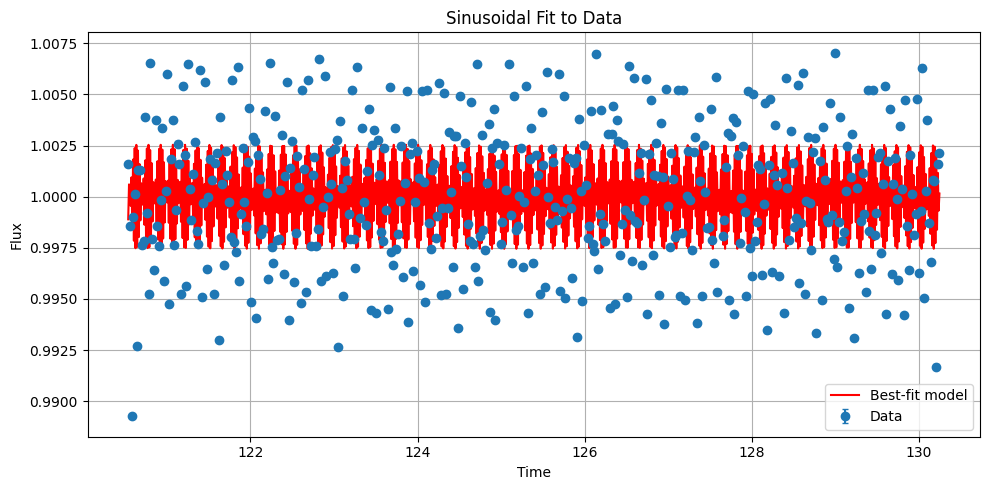

In [74]:
# Plotting sinusoidal model with improved A, B, and C
t_fit = np.linspace(np.min(t_clean), np.max(t_clean), 1000)  # Use t_clean for fitting range
flux_fit = sinusoidal_model(t_fit, A_best, B_best, C_best)


plt.figure(figsize=(10, 5))
plt.errorbar(t_clean_unmasked, flux_clean_unmasked, yerr=sigma_clean_unmasked, fmt='o', label='Data', capsize=2)
plt.plot(t_fit, flux_fit, color='red', label='Best-fit model')
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title("Sinusoidal Fit to Data")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()